In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # it has not great performance comapred to dataset 
## see https://www.tensorflow.org/tutorials/load_data/images

import os
import numpy as np
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)

In [3]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import itertools
import sklearn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [195]:
PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/data/'

#(IMG_HEIGHT, IMG_WIDTH)=(227,227) # to be determined for the pretrained
(IMG_HEIGHT, IMG_WIDTH)=(224,224) # to be determined for the pretrained

In [196]:
#how many
num_covid = len(os.listdir(os.path.join(os.path.dirname(PATH), 'COVID-19')))
num_normal = len(os.listdir(os.path.join(os.path.dirname(PATH), 'NORMAL')))
num_viral = len(os.listdir(os.path.join(os.path.dirname(PATH), 'ViralPneumonia')))
num_covid,num_normal,num_viral  # imbalanced!!!!! maybe before DataGenerator we should split with stratified version from scikit


(219, 1341, 1345)

In [197]:
train_datagen = ImageDataGenerator(rescale=1./255,
        validation_split=0.2)

train_data_gen = train_datagen.flow_from_directory(batch_size=32,color_mode= "grayscale",
                                                           directory=PATH,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse', subset='training')

Found 2325 images belonging to 3 classes.


In [198]:
covid=len(np.where(train_data_gen.classes==0)[0])
normal= len(np.where(train_data_gen.classes==1)[0])
viral= len(np.where(train_data_gen.classes==2)[0])
covid, normal, viral

(176, 1073, 1076)

In [199]:
val_data_gen = train_datagen.flow_from_directory(batch_size=32,
                                                              directory=PATH,color_mode= "grayscale",
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              shuffle=False,
                                                              class_mode='sparse', subset='validation')

Found 580 images belonging to 3 classes.


In [200]:
total_train = 2325
total_val=580
batch_size=32

### Visualize training images

Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with `matplotlib`.

In [201]:
sample_training_images, labels = next(train_data_gen)

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.

In [202]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax,l in zip( images_arr, axes, labels):
        ax.imshow(img.reshape((IMG_HEIGHT, IMG_WIDTH)), cmap='gray')
        ax.axis('off')
        ax.set_title(l, loc='center', y=1.1)
    plt.tight_layout()
    plt.show()

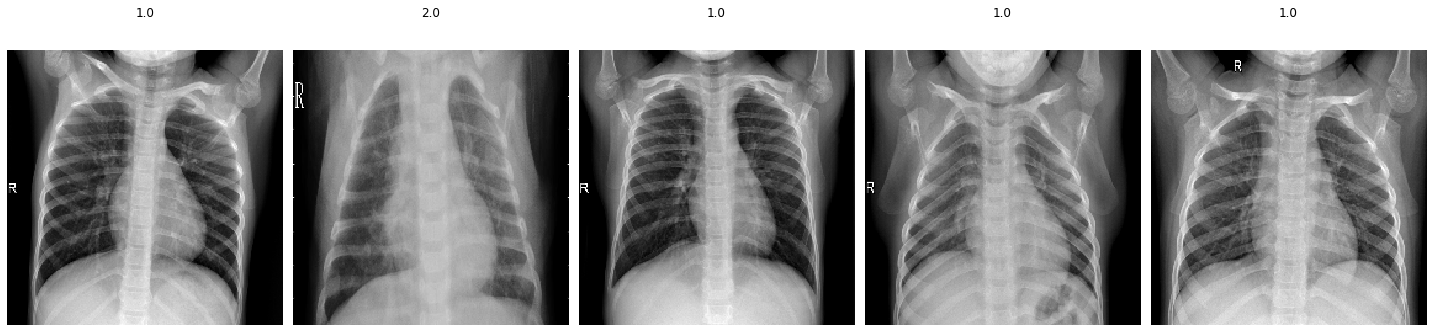

In [203]:
plotImages(sample_training_images[:5], labels[:5])

In [180]:
total_train = covid+normal+viral
weight_for_0 = (1 / covid)*total_train/3.0 
weight_for_1 = (1 / normal)*total_train/3.0
weight_for_2 = (1 / viral)*total_train/3.0
class_weight = {0: weight_for_0, 1: weight_for_1, 2:weight_for_2}
print(class_weight)
total_val=len(val_data_gen.classes)
print(total_train, total_val)

{0: 4.403409090909091, 1: 0.7222739981360671, 2: 0.720260223048327}
2325 580


In [6]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 227, 227, 16)      160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 113, 113, 16)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 113, 113, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [40]:
#alternativa de incarcare imagine
#IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/data/COVID-19/COVID-19 (22).png'
IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/diverse/normal.jpeg'
#img=X[0]
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(227, 227), color_mode='grayscale')
img = tf.keras.preprocessing.image.img_to_array(img)
img=img/255
img_file0=img[:,:,0]

In [42]:
#X[0] de ce e diferit de img?
model.predict(np.array([img]))

array([[9.9999881e-01, 1.2102851e-07, 1.0362138e-06]], dtype=float32)

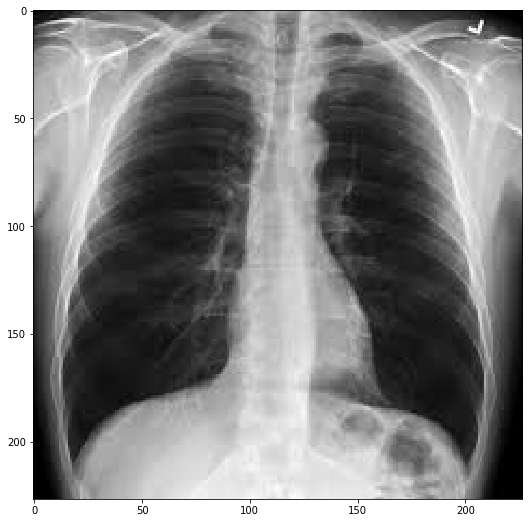

In [43]:
#plt.imshow(X[0, :,:,0], cmap='gray')
plt.figure(figsize=(9,9))
plt.imshow(img_file0, cmap='gray')
plt.show()

In [44]:

# Extracts the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = Model(inputs=model.input, outputs=layer_outputs)

In [46]:
model.layers[0].output

<tf.Tensor 'conv2d_12/Identity:0' shape=(None, 227, 227, 16) dtype=float32>

When fed an image input, this model returns the values of the layer activations in the original model. Until now the models you have seen only had exactly one input and one output. In the general case, a model could have any number of inputs and outputs. This one has one input and 8 outputs, one output per layer activation.

In [120]:
# This will return a list of 8 Numpy arrays:
# one array per layer activation
X=np.array([img])
activations = activation_model.predict(X)
len(activations)

6

In [121]:
#Activation of the first convolution layer for our image input:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 227, 227, 16)


 It's 227x227 feature map with 16 channels. Let's try visualizing the 3rd channel:

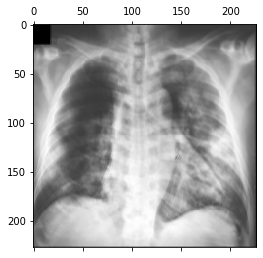

In [125]:
plt.matshow(first_layer_activation[0, :, :, 2], cmap='gray')
plt.show()

/home/justdoit/.conda/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide


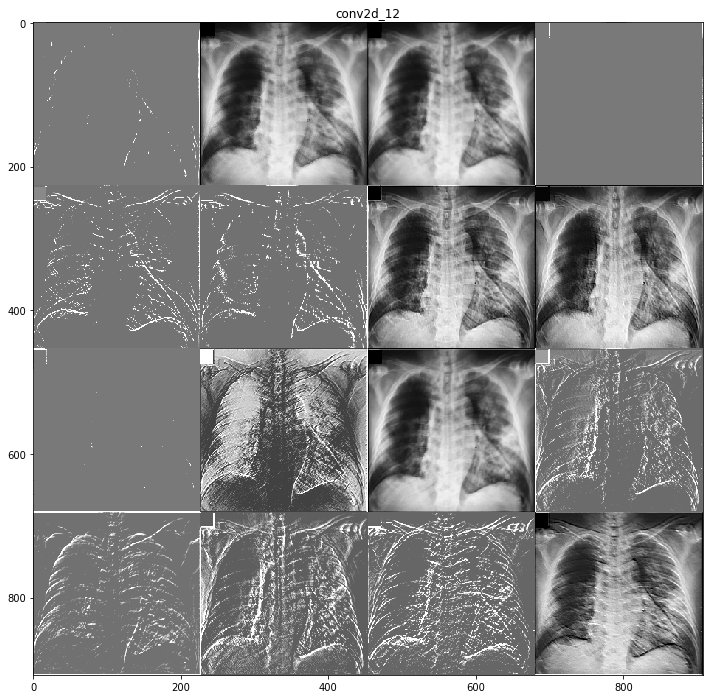

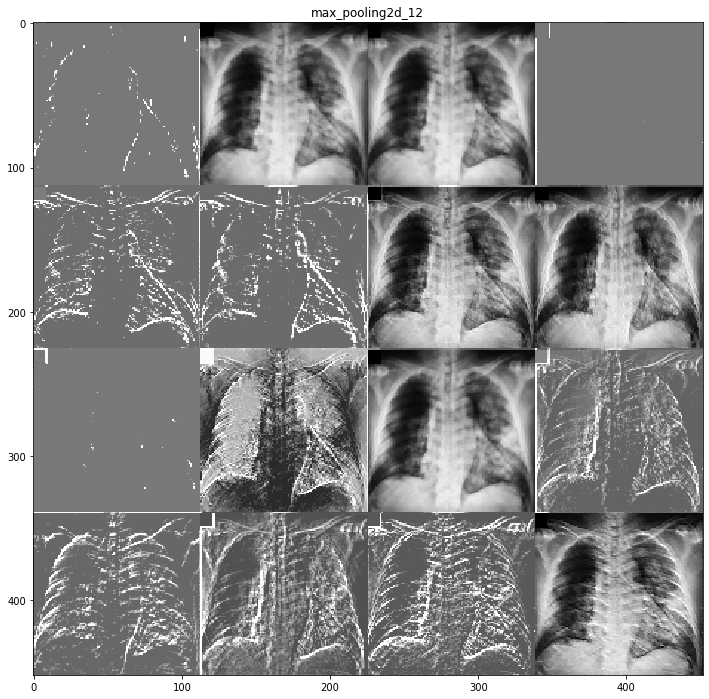

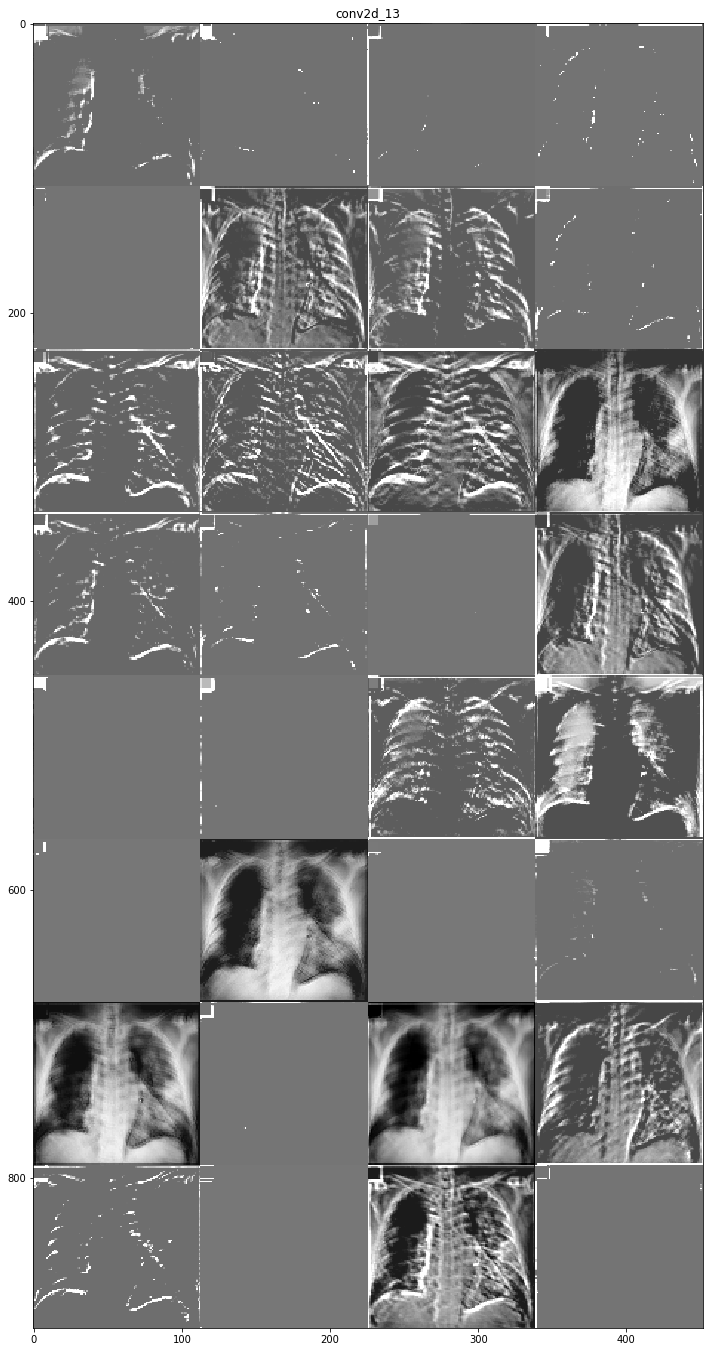

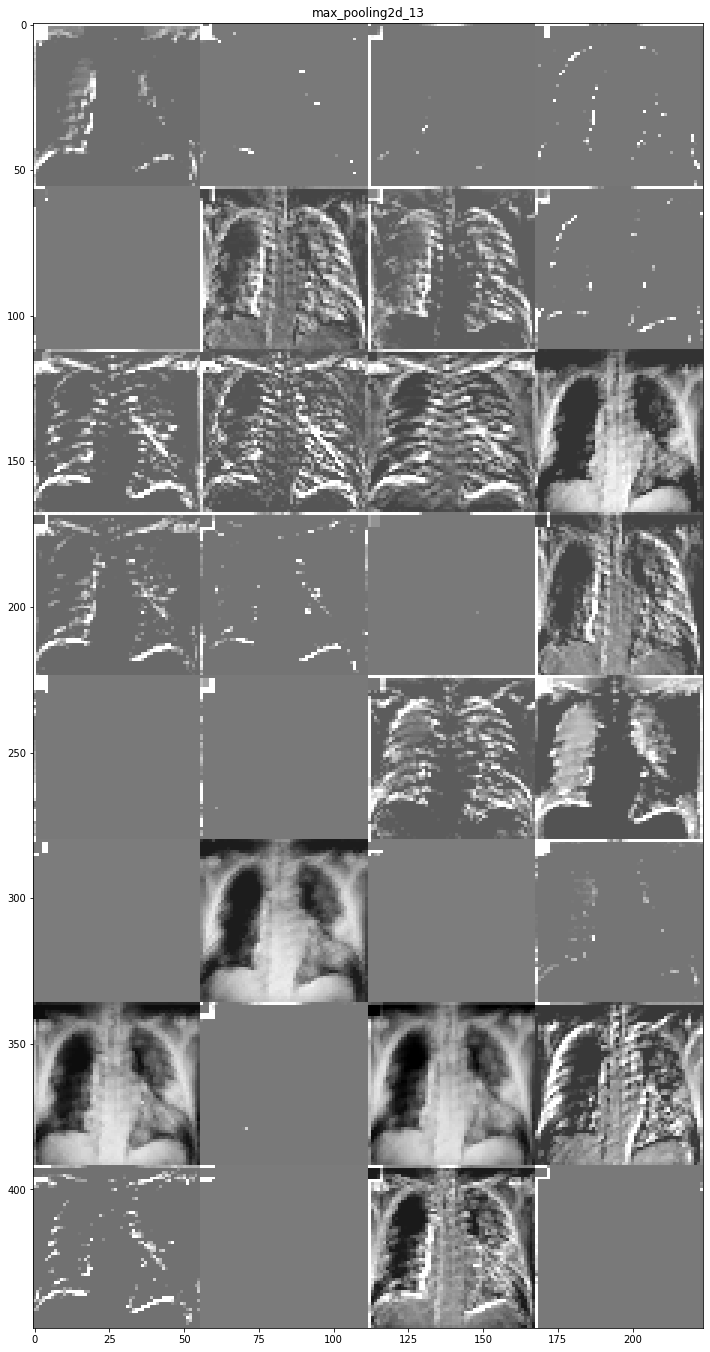

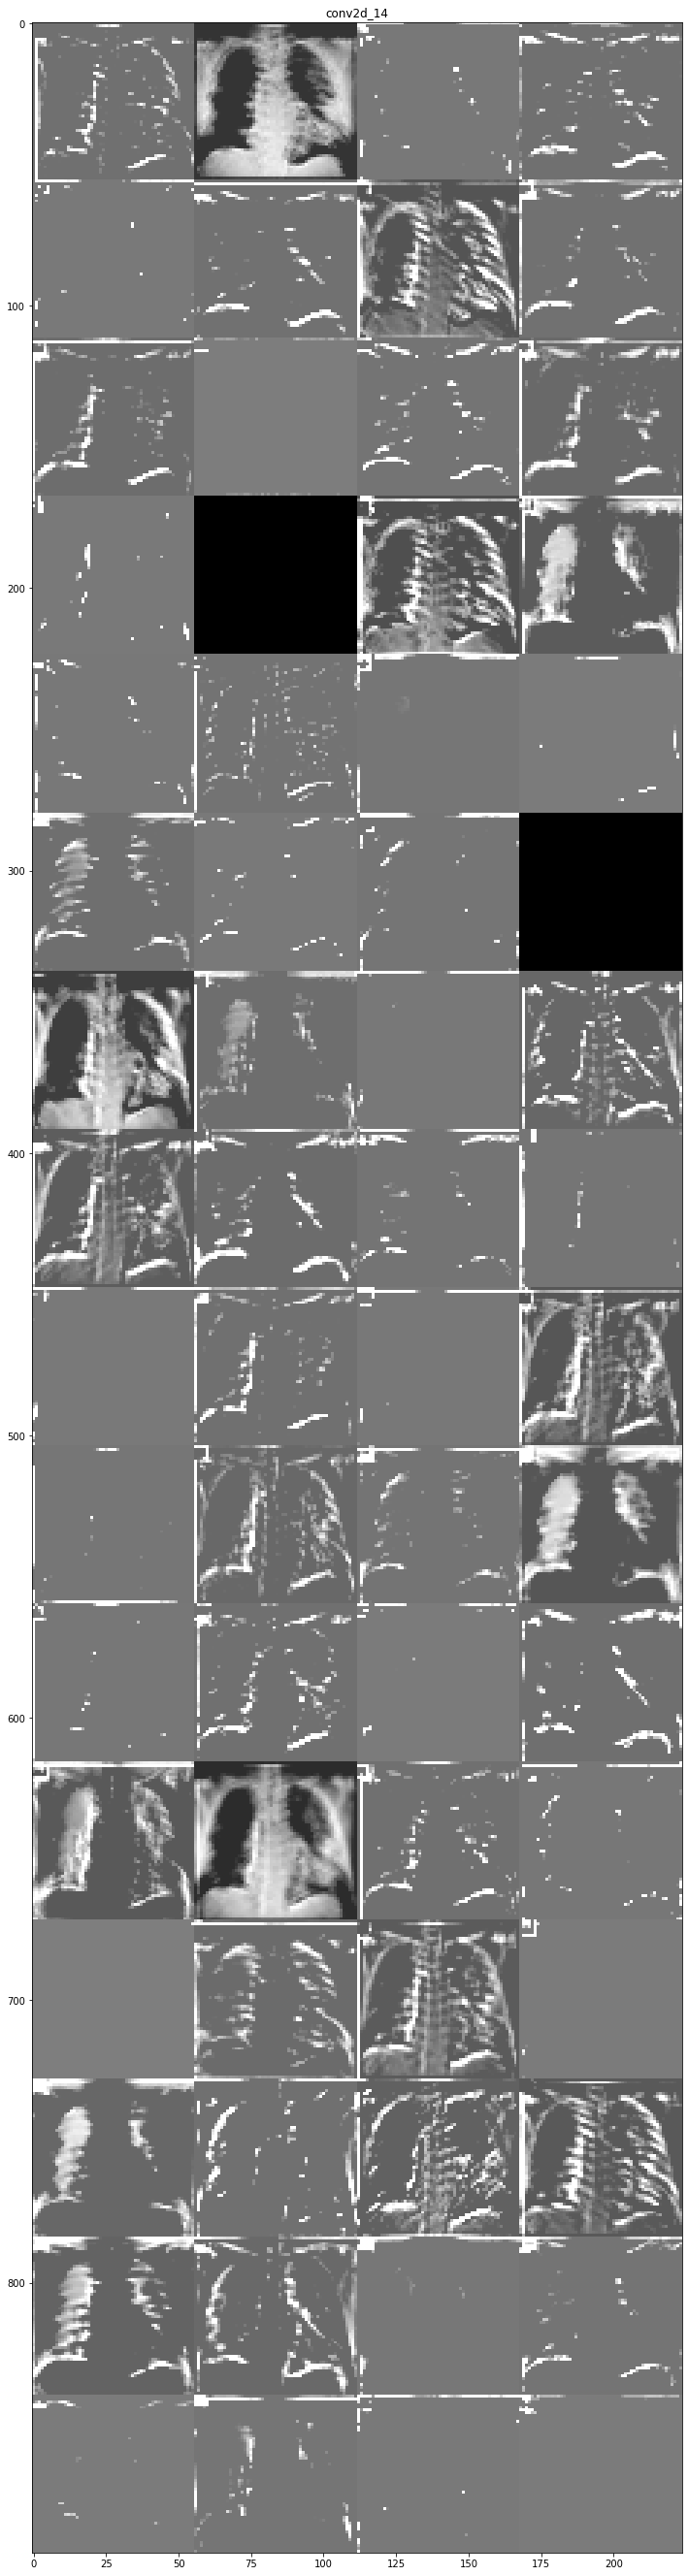

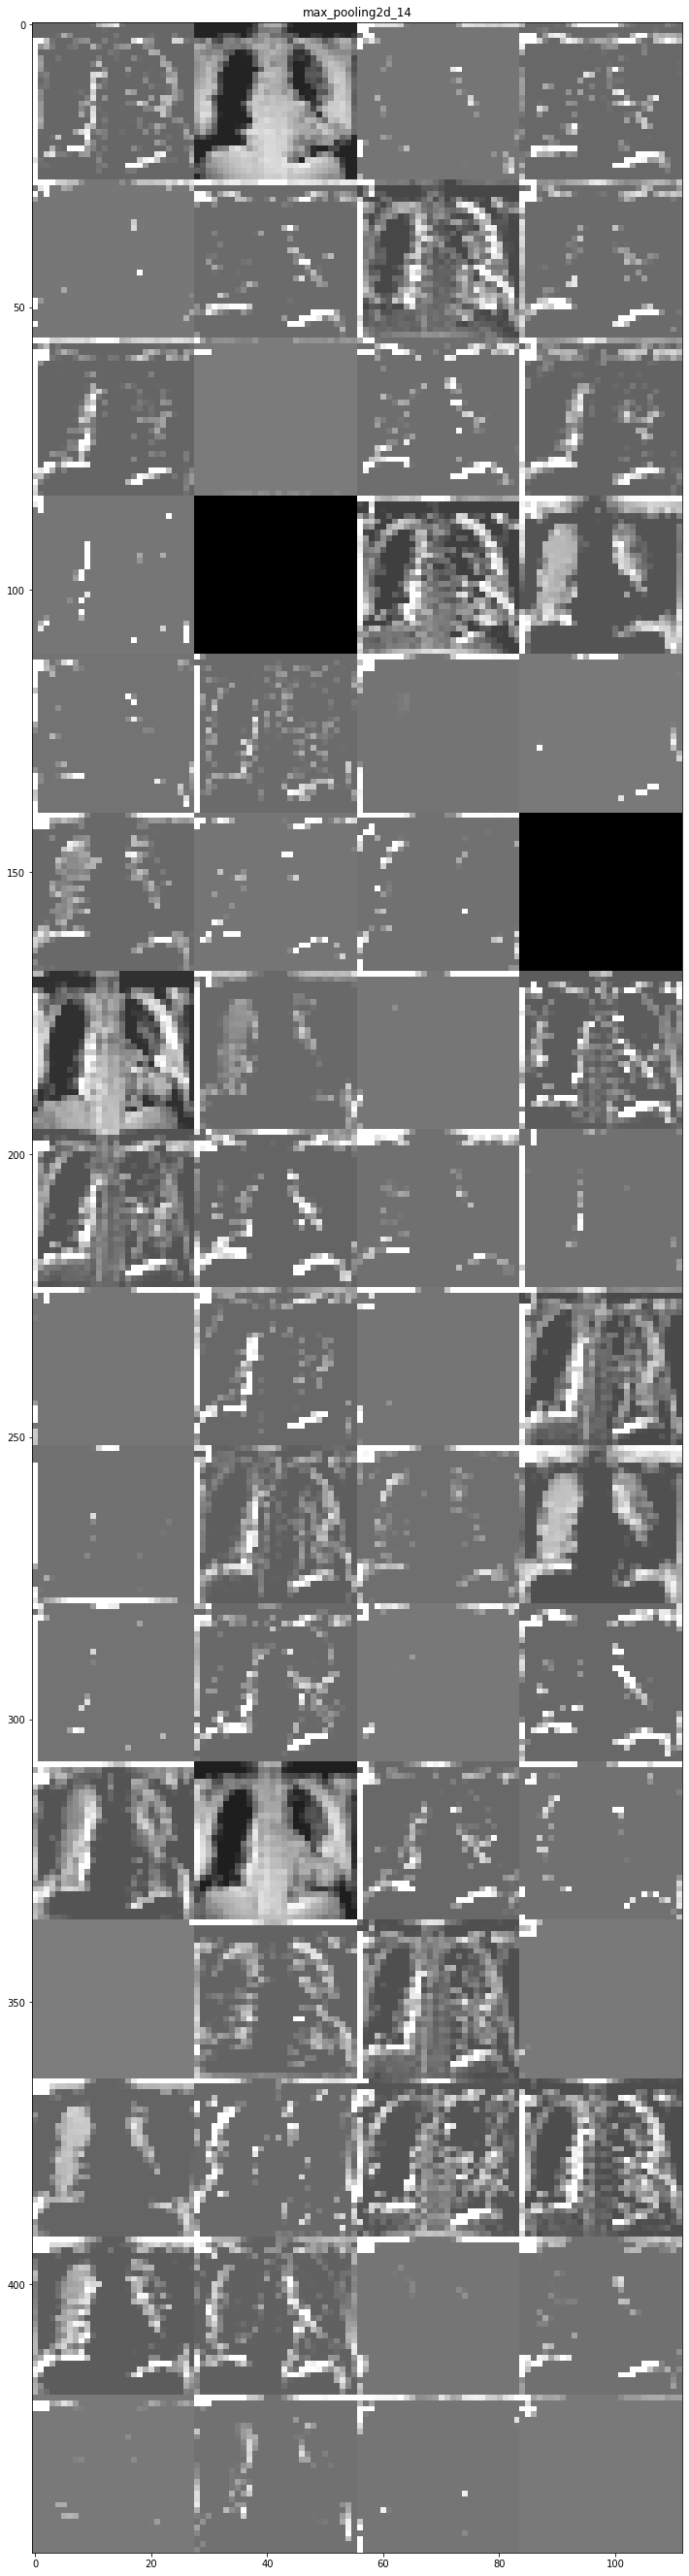

In [126]:
#Chollet Deep Learning woth Python
def plot_layers(activations):#These are the names of the layers, so can have them as part of our plot
    layer_names = []
    for layer in model.layers[:6]:
        layer_names.append(layer.name)

    images_per_row = 4

    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names, activations):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable

                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 3*1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

    plt.show()
plot_layers(activations)

In [56]:
pred = model.predict(np.array([img/255]))
predicted_class = np.argmax(pred[0])
pred, predicted_class

(array([[9.9999881e-01, 1.2102851e-07, 1.0362138e-06]], dtype=float32), 0)

/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/myresults/vggCOVID-19 (23).png


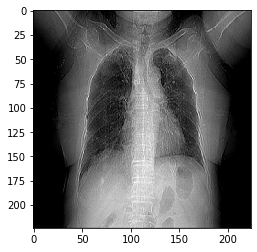

In [313]:
IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/data/COVID-19/COVID-19 (23).png'
#IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/data/NORMAL/NORMAL (10).png'
#IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/myresults/modifCOVID-19 (01).png'
TO_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/myresults/vgg'+IMAGE_PATH.split('/')[-1]
print(TO_PATH)

dim=224#227
#IMAGE_PATH = '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/diverse/normal.jpeg'
#IMAGE_PATH='/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/chest-xray-pneumonia/chest_xray/chest_xray/test/NORMAL'
#img=X[0]
#img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(dim, dim), color_mode='grayscale')
img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(dim, dim))
img = tf.keras.preprocessing.image.img_to_array(img)
img=img/255
plt.imshow(img[:,:,0], cmap='gray')
#plt.show()

Prediction: [[9.9962759e-01 3.7184008e-04 5.7918584e-07]]
tf.Tensor([[9.9962759e-01 3.7184008e-04 5.7918584e-07]], shape=(1, 3), dtype=float32)


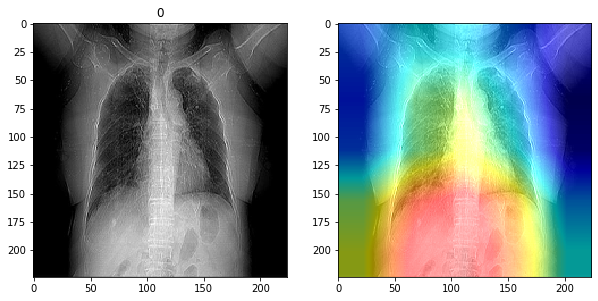

In [314]:
fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].imshow(img[:,:,0], cmap='gray')

#simple model LAYER_NAME = 'conv2d_14'
LAYER_NAME ='conv2d_18'

model = model_transfer
dim =224 #227

pred = model.predict(np.array([img]))
print("Prediction:",pred)
predicted_class = np.argmax(pred[0]) # there is only one output with 3 classes
CAT_CLASS_INDEX = predicted_class

grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])


#CAT_CLASS_INDEX=2

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(np.array([img]))
    loss = predictions[:, CAT_CLASS_INDEX]
    print(predictions)

output = conv_outputs[0]
grads = tape.gradient(loss, conv_outputs)[0]

gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam = cam+w * output[:, :, i]
   # print("w:\n", w, "o:", output[:,:,i][0:2])
if cam.numpy().max() ==cam.numpy().min():
    print("***************************Nothing really happens in the network when computing cam - so heatmap will be blank", cam[0][0:4])
    #print(cam.numpy())
cam = cv2.resize(cam.numpy(), (dim, dim))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())
#print('\n'.join([' '.join(['{:.2f}'.format(item) for item in row]) 
#      for row in heatmap]))
#print(heatmap[100:110,100:110])

# We convert the heatmap to RGB
heatmap = np.uint8(255 * heatmap)



cam = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor((255*img).astype('uint8'), cv2.COLOR_RGB2BGR), 1, cam, 0.6, 0)
axs[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)) #see BGR to RGB cv2 cv2 keeps the colors differently
axs[0].set_title(predicted_class)
cv2.imwrite('cam.png', output_image)

plt.savefig(TO_PATH)
plt.show()



### with transfer knowledge

In [289]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=25,
                                                            width_shift_range=.15,
                                                            height_shift_range=.15,
                                                           zoom_range=0.25,
        validation_split=0.2)

train_data_gen = train_datagen.flow_from_directory(batch_size=32,
                                                           directory=PATH,
                                                           
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='sparse', subset='training')

val_data_gen = train_datagen.flow_from_directory(batch_size=32,
                                                              directory=PATH,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              shuffle=False,
                                                              class_mode='sparse', subset='validation')

Found 2325 images belonging to 3 classes.
Found 580 images belonging to 3 classes.


In [303]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# UnFreeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:-4]:
    layer.trainable =  False


Number of layers in the base model:  19


In [304]:
model_transfer = tf.keras.Sequential([
  base_model,
  Conv2D(512, kernel_size = (3,3), padding = 'valid'),
  MaxPooling2D(pool_size=(2, 2)),
  Flatten(),
  Dropout(0.4) , 
  Dense(512, activation='relu'),
  Dense(3, activation='softmax')
])
model_transfer.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 5, 512)         2359808   
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 2, 2, 512)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_37 (Dense)             (None, 3)               

In [305]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('vggweights.{epoch:03d}-{val_loss:.3f}.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

model_transfer.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001/2.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
history = model_transfer.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=20,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size, 
    class_weight=class_weight, 
    callbacks=[checkpoint]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 72 steps, validate for 18 steps
Epoch 1/20
72/72 [==============================] - 59s 816ms/step - loss: 0.6703 - accuracy: 0.7296 - val_loss: 0.2826 - val_accuracy: 0.8889
Epoch 2/20
72/72 [==============================] - 57s 794ms/step - loss: 0.3614 - accuracy: 0.8609 - val_loss: 0.2050 - val_accuracy: 0.9097
Epoch 3/20
72/72 [==============================] - 59s 818ms/step - loss: 0.2475 - accuracy: 0.8949 - val_loss: 0.2183 - val_accuracy: 0.8802
Epoch 4/20
72/72 [==============================] - 58s 807ms/step - loss: 0.2294 - accuracy: 0.9041 - val_loss: 0.2147 - val_accuracy: 0.8837
Epoch 5/20
72/72 [==============================] - 58s 802ms/step - loss: 0.2050 - accuracy: 0.9128 - val_loss: 0.1741 - val_accuracy: 0.9323
Epoch 6/20
72/72 [==============================] - 58s 801ms/step - loss: 0.1933 - accuracy: 0.9206 - val_loss: 0.1371 - val_accuracy: 0.9392
Epoch 7/20
72/72 [==============================] 

19/19 [==============================] - 11s 585ms/step

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        43
      normal       0.95      0.95      0.95       268
       viral       0.95      0.95      0.95       269

    accuracy                           0.95       580
   macro avg       0.97      0.97      0.97       580
weighted avg       0.95      0.95      0.95       580



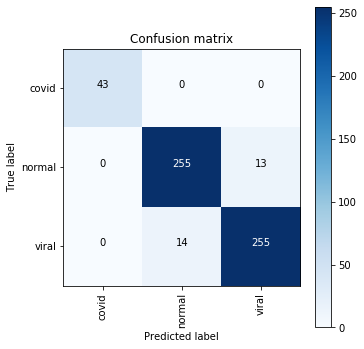

In [316]:
chosen_model =tf.keras.models.load_model( '/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/curs/deepLearning/d3/vggweights.018-0.09.hdf5')
#entire dataset
val_data_gen.reset()
#score = model.evaluate(val_data_gen, verbose=1)
#print(score)
pred=chosen_model.predict(val_data_gen,verbose=1)

val_data_gen.classes
pred_indices = np.argmax(pred,axis=1)
confusion_mtx = confusion_matrix(val_data_gen.classes, pred_indices) 
plot_confusion_matrix(confusion_mtx, ['covid', 'normal', 'viral'] )
print('\n', sklearn.metrics.classification_report(val_data_gen.classes, pred_indices, target_names=['covid', 'normal', 'viral']), sep='') 

In [317]:
chosen_model.save('/mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/models/chosen_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /mnt/7ac346ab-63e9-4291-b1d0-6ac9ad09954a/work/covid/COVID-19RadiographyDatabase/models/chosen_model/assets
